# AUTOENCODER for Supervised Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [28]:
# Load data
df_MCF7 = pd.read_csv("DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",
                 delim_whitespace=True,
                 header=0,
                 quotechar='"',
                 index_col=0,
                 engine="python")

print("Original data shape (genes x samples):", df_MCF7.shape)

# Transpose the data so that rows are samples and columns are genes/features
X_MCF7 = df_MCF7.T.values
print("Transposed data shape (samples x features):", X_MCF7.shape)

df_HCC = pd.read_csv("DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",
                 delim_whitespace=True,
                 header=0,
                 quotechar='"',
                 index_col=0,
                 engine="python")

print("Original data shape (genes x samples):", df_HCC.shape)

# Transpose the data so that rows are samples and columns are genes/features
X_HCC = df_HCC.T.values
print("Transposed data shape (samples x features):", X_HCC.shape)

C:\Users\flamo\AppData\Local\Temp\ipykernel_4828\3969746558.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_MCF7 = pd.read_csv("DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",


Original data shape (genes x samples): (3000, 21626)
Transposed data shape (samples x features): (21626, 3000)


C:\Users\flamo\AppData\Local\Temp\ipykernel_4828\3969746558.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_HCC = pd.read_csv("DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",


Original data shape (genes x samples): (3000, 14682)
Transposed data shape (samples x features): (14682, 3000)


In [29]:
# Extract condition information from column names
sample_names_MCF7 = df_MCF7.columns
conditions_M = []
for name in sample_names_MCF7:
    if "Norm" in name:
        conditions_M.append("Norm")
    elif "Hypo" in name:
        conditions_M.append("Hypo")
    else:
        conditions_M.append("Unknown")

# Create condition color mapping
colors_M = ["blue" if c == "Norm" else "red" if c == "Hypo" else "gray" for c in conditions_M]
condition_labels_M = np.array([0 if c == "Norm" else 1 if c == "Hypo" else 2 for c in conditions_M])

# Extract condition information from column names
sample_names_HCC = df_HCC.columns
conditions_H = []
for name in sample_names_HCC:
    if "Norm" in name:
        conditions_H.append("Norm")
    elif "Hypo" in name:
        conditions_H.append("Hypo")
    else:
        conditions_H.append("Unknown")

# Create condition color mapping
colors_H = ["blue" if c == "Norm" else "red" if c == "Hypo" else "gray" for c in conditions_H]
condition_labels_H = np.array([0 if c == "Norm" else 1 if c == "Hypo" else 2 for c in conditions_H])

In [30]:
scaler = StandardScaler()
# Step 1: CPM Normalization
def normalize_cpm(counts_df):
    counts_sum = counts_df.sum(axis=0)  # Total counts per sample
    cpm = counts_df.divide(counts_sum, axis=1) * 1000
    return cpm

# Step 2: Log Transformation (log2(CPM + 1))
def log_transform(cpm_df):
    log_cpm = np.log2(1 + cpm_df)
    return log_cpm
# Step 3: Min-Max Scaling to [0,1] for each gene (row-wise)
def min_max_scale(df):
    return (df.subtract(df.min(axis=1), axis=0)
              .divide(df.max(axis=1) - df.min(axis=1), axis=0))

# Rows = genes, Columns = samples

cpm_df = normalize_cpm(df_MCF7)
log_cpm_df = log_transform(cpm_df)
X_preprocessed_M = min_max_scale(log_cpm_df)
# X_preprocessed = scaler.fit_transform(log_cpm_df.T)

cpm_df = normalize_cpm(df_HCC)
log_cpm_df = log_transform(cpm_df)
X_preprocessed_H = min_max_scale(log_cpm_df)

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Parameters
input_dim = X_HCC.shape[1]  # Number of genes
latent_dim = 100    # Size of the bottleneck

# Encoder
input_layer = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(512, activation='relu')(input_layer)
# x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu')(x)
# x = layers.Dropout(0.1)(x)
latent = layers.Dense(latent_dim, activation='linear')(x)

# Decoder (mirroring encoder)
x = layers.Dense(128, activation='relu')(latent)
# x = layers.Dropout(0.1)(x)
x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.1)(x)
output_layer = layers.Dense(input_dim, activation='sigmoid')(x)

# Autoencoder model
autoencoder_H = models.Model(inputs=input_layer, outputs=output_layer)
autoencoder_H.compile(optimizer='adam', loss="mae")  # Use MSE for normalized data
#
#tf.keras.losses.CosineSimilarity(
#     axis=-1,
#     reduction='sum_over_batch_size',
#     name='cosine_similarity'
# )
# Summary
autoencoder_H.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │     1,536,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3000)           │     1,539,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,233,052 (12.33 MB)

 Trainable params: 3,233,052 (12.33 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Parameters
input_dim = X_MCF7.shape[1]  # Number of genes
latent_dim = 100    # Size of the bottleneck

# Encoder
input_layer = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(input_layer)
# x = layers.Dropout(0.1)(x)
x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.1)(x)
latent = layers.Dense(latent_dim, activation='linear')(x)

# Decoder (mirroring encoder)
x = layers.Dense(128, activation='relu')(latent)
# x = layers.Dropout(0.1)(x)
x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.1)(x)
output_layer = layers.Dense(input_dim, activation='sigmoid')(x)

# Autoencoder model
autoencoder_M = models.Model(inputs=input_layer, outputs=output_layer)
autoencoder_M.compile(optimizer='adam', loss="mae")  # Use MSE for normalized data
#
#tf.keras.losses.CosineSimilarity(
#     axis=-1,
#     reduction='sum_over_batch_size',
#     name='cosine_similarity'
# )
# Summary
autoencoder_M.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │       384,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 3000)           │     1,539,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,119,452 (8.09 MB)

 Trainable params: 2,119,452 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from sklearn.model_selection import train_test_split

X_train_H, X_test_H, y_train_H, y_test_H = train_test_split(X_preprocessed_H.values.T, condition_labels_H, stratify=condition_labels_H,  test_size= 0.1, random_state=11)
print(X_train_H.shape, X_test_H.shape, y_train_H.shape, y_test_H.shape)

X_train_M, X_test_M, y_train_M, y_test_M = train_test_split(X_preprocessed_M.values.T, condition_labels_M, stratify=condition_labels_M,  test_size= 0.1, random_state=11)
print(X_train_M.shape, X_test_M.shape, y_train_M.shape, y_test_M.shape)

(13213, 3000) (1469, 3000) (13213,) (1469,)
(19463, 3000) (2163, 3000) (19463,) (2163,)


In [34]:
history = autoencoder_H.fit(X_train_H, X_train_H,
                epochs=1000,
                batch_size=500,
                shuffle = True,
                validation_data=(X_test_H, X_test_H),
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True)])

Epoch 1/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.3228 - val_loss: 0.0134
Epoch 2/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0135 - val_loss: 0.0137
Epoch 3/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 4/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0137 - val_loss: 0.0137
Epoch 5/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0137 - val_loss: 0.0137
Epoch 6/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 7/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 8/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 9/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 10/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 11/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 12/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 

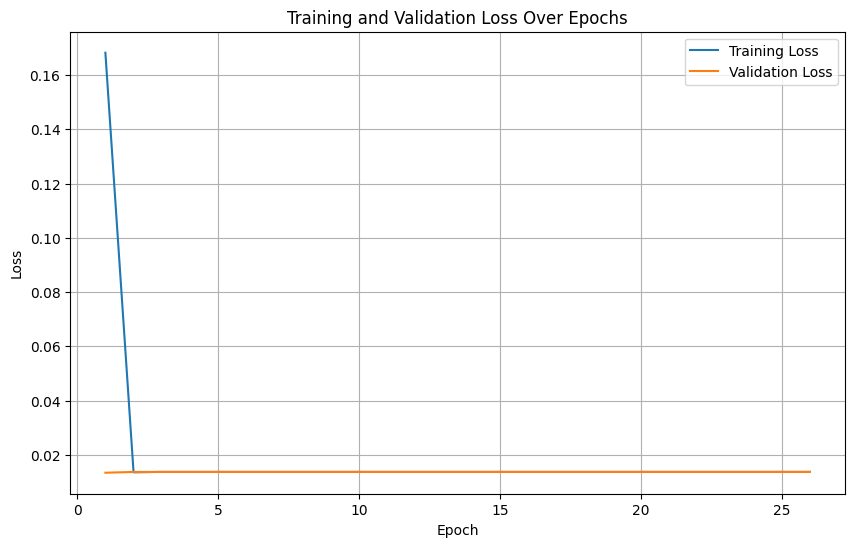

In [35]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
history2 = autoencoder_M.fit(X_train_M, X_train_M,
                epochs=50,
                batch_size=500,
                shuffle = True,
                validation_data=(X_test_M, X_test_M),)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2853 - val_loss: 0.0148
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0147 - val_loss: 0.0148
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0147 - val_loss: 0.0148
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0147 - val_loss: 0.0148
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0147 - val_loss: 0.0148
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0

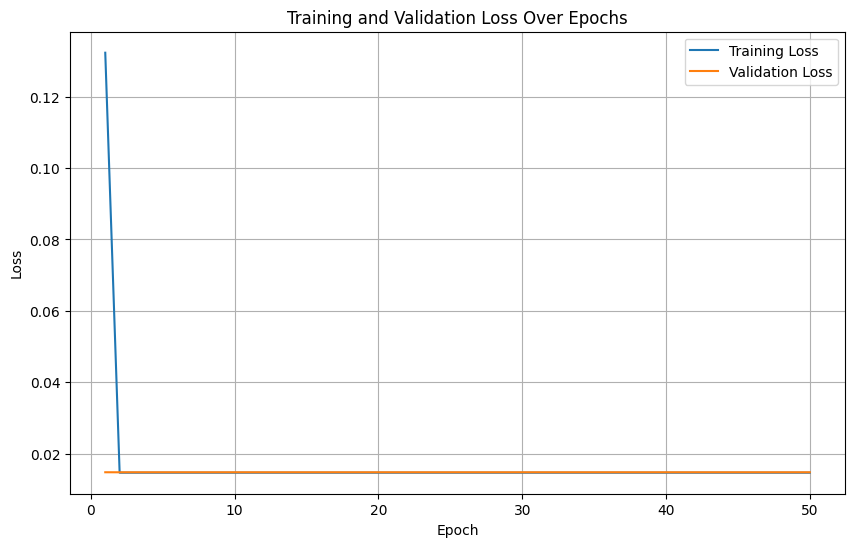

In [37]:
# Extract loss values
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


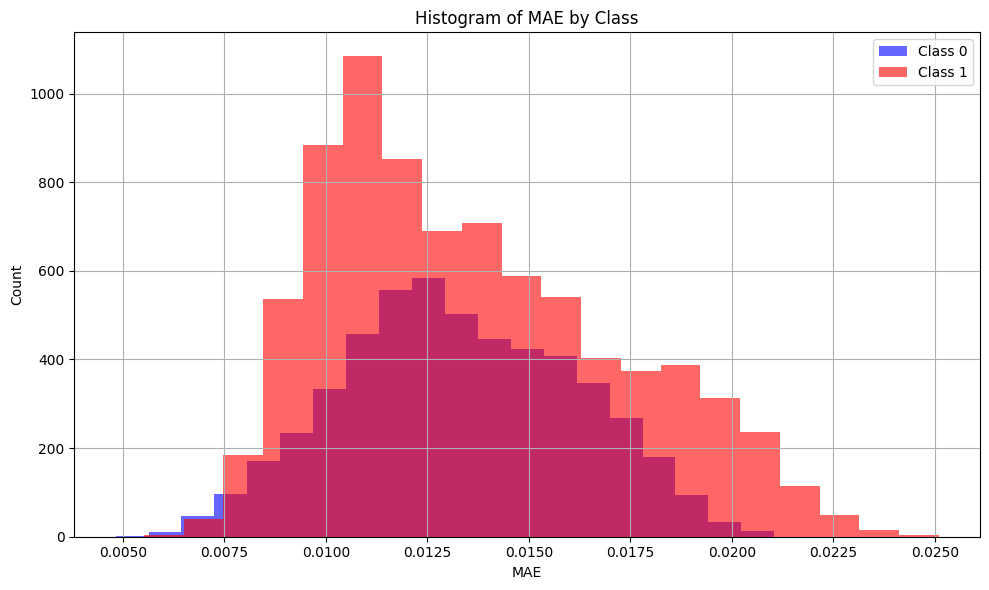

In [38]:
# 1. Get reconstruction from the autoencoder
reconstructions_H = autoencoder_H.predict(X_train_H)

# 2. Compute Mean Absolute Error (MAE) for each sample
mae = np.mean(np.abs(reconstructions_H - X_train_H), axis=1)

# 3. Separate MAE values by class
mae_class_0 = mae[y_train_H == 0]
mae_class_1 = mae[y_train_H == 1]

# 4. Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(mae_class_0, bins=20, alpha=0.6, label='Class 0', color='blue')
plt.hist(mae_class_1, bins=20, alpha=0.6, label='Class 1', color='red')
plt.xlabel('MAE')
plt.ylabel('Count')
plt.title('Histogram of MAE by Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


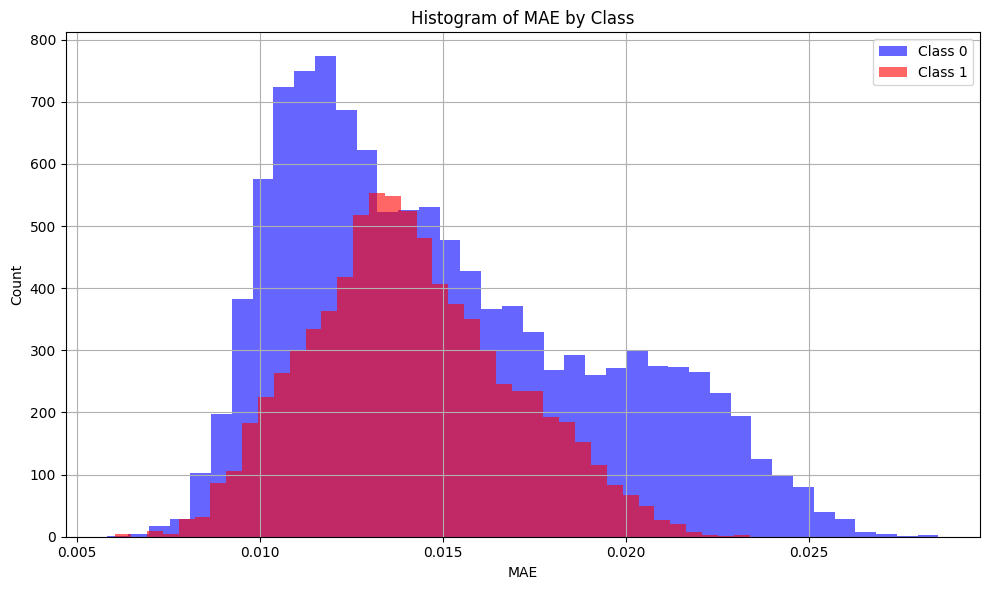

In [ ]:
# 1. Get reconstruction from the autoencoder
reconstructions_M = autoencoder_M.predict(X_train_M)

# 2. Compute Mean Absolute Error (MAE) for each sample
mae = np.mean(np.abs(reconstructions_M - X_train_M), axis=1)

# 3. Separate MAE values by class
mae_class_0 = mae[y_train_M == 0]
mae_class_1 = mae[y_train_M == 1]

# 4. Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(mae_class_0, bins=40, alpha=0.6, label='Class 0', color='blue')
plt.hist(mae_class_1, bins=40, alpha=0.6, label='Class 1', color='red')
plt.xlabel('MAE')
plt.ylabel('Count')
plt.title('Histogram of MAE by Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()